# Simple regression model selection


In [22]:
from typing import NamedTuple
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from pcv.inference import run_cv_sel
from pcv.welford import *
from pcv.plots import plot_model_results, plot_fold_results
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## Model definition

Gaussian linear regression

In [23]:
class Theta(NamedTuple):
    beta: jax.Array
    sigsq: jax.Array

In [24]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 1.0, 1.0, 0.5])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)

To break inference, simply inject an outlier into the data. Remember jax arrays are immutable so we need this stange syntax.

In [25]:
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

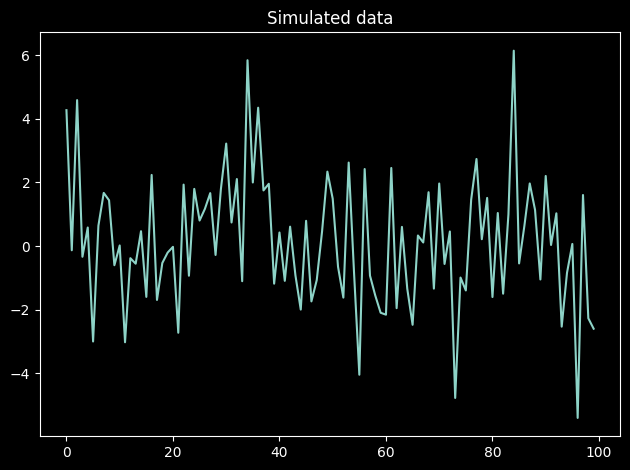

In [26]:
plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [27]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)


def logjoint_density(theta: Theta, fold_id: int, model_id: int) -> jax.Array:
    """Log joint density for a given fold.
    
    Args:
      theta: model parameters
      fold_id: zero-based fold id for training set
      model_id: 0 for model A, 1 for model B
    """
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
    # prior is same for all folds
    lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
    # likelihood for fold
    ll_mask = ((jnp.arange(N) % 5) != fold_id).astype(jnp.float32)
    # model A has all the predictors, model B is missing the last predictor
    beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
    ll_contribs = tfd.Normal(loc=X @ (theta.beta * beta_mask), scale=jnp.sqrt(sigsq)).log_prob(y)
    ll = (ll_mask * ll_contribs).sum()
    return lp + ll + sigsq_ldj


# predictive density log p(y_train|theta)
def log_pred(theta, fold_id, model_id):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    pred_mask = (jnp.arange(N) % 5) == fold_id
    beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
    ll_contribs = tfd.Normal(loc=X @ (theta.beta * beta_mask), scale=jnp.sqrt(sigsq)).log_prob(y)
    return (pred_mask * ll_contribs).sum()


# random initialization in the constrained parameter space
def make_initial_pos(key):
    k1, k2 = jax.random.split(key)
    theta = Theta(
      beta=jax.random.normal(key=k1, shape=(p,)),
      sigsq=jax.random.normal(key=k2))
    return theta


def stoprule(elpd_diff, diff_cvse, model_mcse, model_ess, num_folds, num_samples, model_rhats):
    se = jnp.sqrt(jnp.sum(model_mcse**2) + diff_cvse**2)
    tcrit = tfd.StudentT(df=num_folds+2, loc=0., scale=1.).quantile(0.975)
    return (
        (jnp.abs(elpd_diff/se) > tcrit)
        and (jnp.max(model_rhats) < 1.05)
        and jnp.all(model_ess > 200)
    )


## Inference


In [28]:
inference_key = jax.random.PRNGKey(43)

In [29]:
results = run_cv_sel(
       prng_key=inference_key,
       logjoint_density=logjoint_density,
       log_p=log_pred,
       make_initial_pos=make_initial_pos,
       stoprule=stoprule,
       num_folds=5,
       num_chains=4,
       batch_size=100,
       warmup_iter=1000,
       max_batches=50,
       ignore_stoprule=True
)

MEADS warmup for 5 folds per model (40 chains)...
Completed 40000 warmup iterations in 2 seconds
Starting cross-validation with 40 parallel GHMC chains...


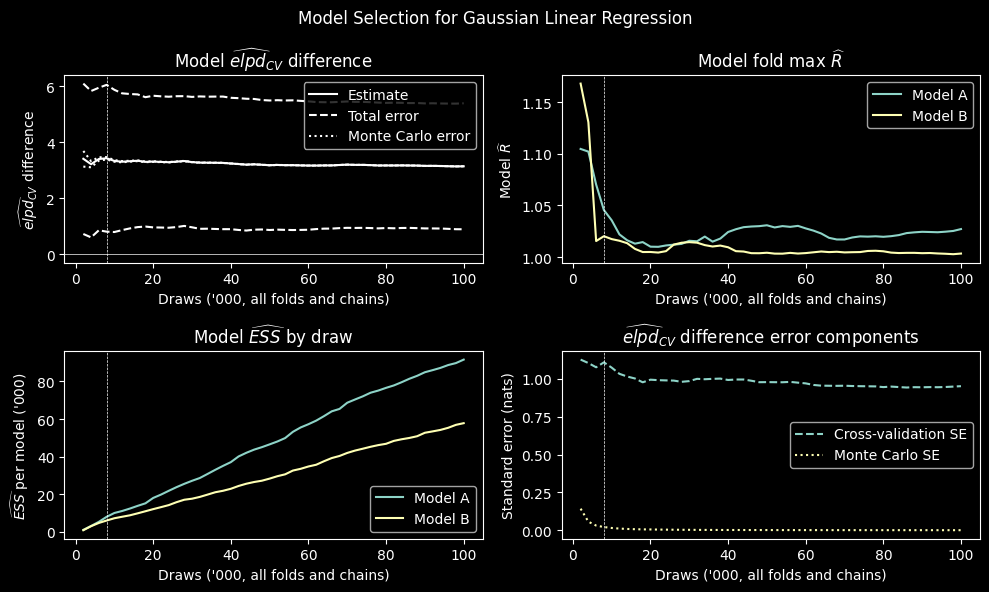

In [ ]:
plot_model_results(results, title="Model Selection for Gaussian Linear Regression")

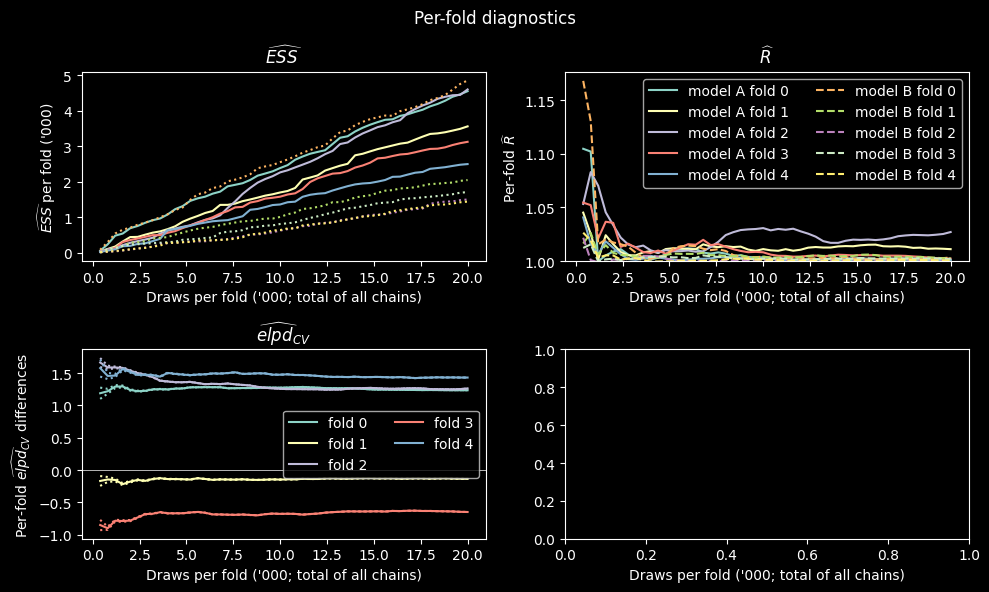

In [ ]:
plot_fold_results(results, title='Per-fold diagnostics')